In [1]:
import torch
import torchvision
print(torch.__version__)
print(torch.cuda.get_device_name(0))



2.5.1
NVIDIA GeForce RTX 3080


In [2]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001
momentum = 0.5
log_interval = 500
input_size = 28 * 28
output_size = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


In [3]:
class ThresholdTransform(object):
  def __call__(self, x):
    return (x > 0.9).to(x.dtype) 

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,)),
                                   ThresholdTransform()
                               ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('files/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                      (0.1307,), (0.3081,)),
                                   ThresholdTransform() 
                               ])),
    batch_size=batch_size_test, shuffle=True)


In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape


torch.Size([1000, 1, 28, 28])

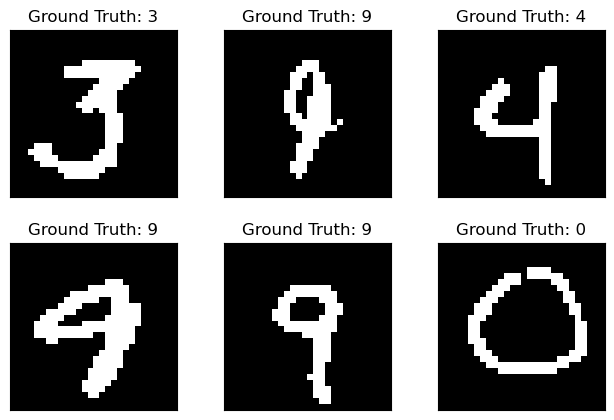

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
device = torch.device("cuda:0")

In [9]:
mid_layer_size = 300 
class FCNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, mid_layer_size)  # First hidden layer with 16 nodes
        self.fc2 = nn.Linear(mid_layer_size, mid_layer_size)         # Second hidden layer with 16 nodes
        self.fc3 = nn.Linear(mid_layer_size, output_size)  # Output layer for classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU after first hidden layer
        x = torch.relu(self.fc2(x))  # ReLU after second hidden layer
        x = self.fc3(x)  # Output layer
        return x

In [10]:
# Initialize the model, loss, and optimizer
model = FCNN(input_size, output_size)
model = model.to(device)
criterion = nn.CrossEntropyLoss()  # Loss for classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [12]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    data = data.view(-1, 28*28)
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), 'results/fcnnModel.pth')
      torch.save(optimizer.state_dict(), 'results/fcnnOptimizer.pth')

In [13]:
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data = data.view(-1, 28*28)
      output: torch.Tensor = model(data)

      _, predicted = torch.max(output, 1)
      correct += predicted.eq(target.data.view_as(predicted)).sum()
      test_loss += criterion(output, target).item()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [14]:
test()



Test set: Avg. loss: 0.0023, Accuracy: 768/10000 (8%)



In [15]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303082
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.147615

Test set: Avg. loss: 0.0001, Accuracy: 9633/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.044724
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.116989

Test set: Avg. loss: 0.0001, Accuracy: 9680/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.050961
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.026388

Test set: Avg. loss: 0.0001, Accuracy: 9744/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.020055
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.019137

Test set: Avg. loss: 0.0001, Accuracy: 9753/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.066832
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.096169

Test set: Avg. loss: 0.0001, Accuracy: 9719/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.012004
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.054476

Test set: Avg. loss: 0.0001, Accuracy: 9760/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.019195
Train Epoch: 7 [32000/60000 (53%)]	Lo

([], [])

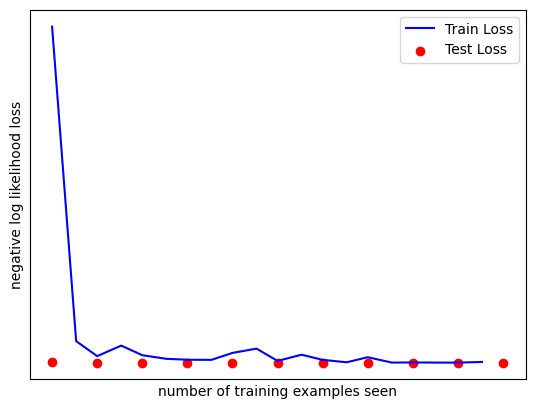

In [16]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.xticks([])
plt.yticks([])

In [17]:
with torch.no_grad():
  data, target = example_data.to(device), example_targets.to(device)
  data = data.view(-1, 28*28)
  output = model(data)

  

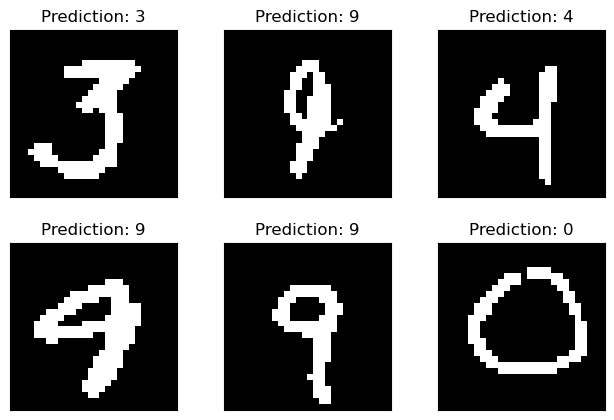

In [18]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

In [19]:
with torch.no_grad():
  data, target = example_data[3].to(device), example_targets[3].to(device)
  data = data.view(-1, 28*28)
  output = model(data)
  torch.set_printoptions(precision=20, sci_mode=False)
  print(output)
  print(nn.Softmax(dim=1)(output))

tensor([[-15.88160419464111328125, -11.80117893218994140625,
         -11.81021118164062500000, -12.96826457977294921875,
           9.79816722869873046875, -14.52475166320800781250,
         -23.17433929443359375000,  -0.93122029304504394531,
          -8.09042263031005859375,   9.97601413726806640625]], device='cuda:0')
tensor([[    0.00000000000320663049,     0.00000000018973832228,
             0.00000000018803245072,     0.00000000005906038159,
             0.45565053820610046387,     0.00000000001245437781,
             0.00000000000000218200,     0.00000997512324829586,
             0.00000000775739739112,     0.54433947801589965820]],
       device='cuda:0')


In [20]:
import json
with open("results/3.json", "w") as f:   
    json.dump(example_data[3].tolist(), f)


In [21]:
import json
with open("results/weights.json", "w") as f:
    json_dict = {}
    for key, value in model.state_dict().items():
        json_dict[key] = value.tolist()
    json.dump(json_dict, f)
